In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['test.zip', 'train.zip']
Python       : 3.8.5 | packaged by conda-forge | (default, Sep 16 2020, 18:01:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


In [9]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = 'data/'
PATH = "car/" # рабочая директория

In [10]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [12]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [13]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


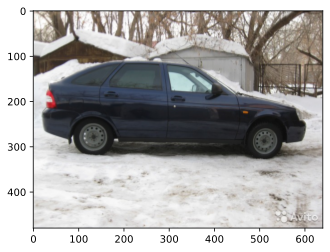

(640, 480)

In [14]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

→ Рекомендация. Добавьте более продвинутые библиотеки аугментации изображений (например, albumentations или imgaug. Для них есть специальные «обёртки» под Keras, например ImageDataAugmentor.

In [17]:
RANDOM_SEED=42
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [18]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [19]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

→ Рекомендация. Попробуйте и другие архитектуры сетей

In [20]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

→ Рекомендация. Попробуйте добавить Batch Normalization.

In [22]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

→ Рекомендации: 

1. Добавьте другие функции из https://keras.io/callbacks/.

2. Используйте разные техники управления Learning Rate. Смотрите статьи на towardsdatascience и teleported.in (ENG).

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.8635 - accuracy: 0.7001
Epoch 00001: saving model to best_model.hdf5
207/207 [==============================] - 1733s 8s/step - loss: 0.8635 - accuracy: 0.7001 - val_loss: 0.3523 - val_accuracy: 0.8725
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9284
Epoch 00002: saving model to best_model.hdf5
207/207 [==============================] - 1728s 8s/step - loss: 0.1979 - accuracy: 0.9284 - val_loss: 0.2578 - val_accuracy: 0.9081
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.9628
Epoch 00003: saving model to best_model.hdf5
207/207 [==============================] - 1735s 8s/step - loss: 0.1047 - accuracy: 0.9628 - val_loss: 0.2379 - val_accuracy: 0.9163
Epoch 4/5
207/207 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9746
Epoch 0000

→ Рекомендация. Попробуйте применить transfer learning с finetuning.

In [ ]:
model.save('/working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

В итоге точность нашей модели составила 90,73 %. Учитывая, что классов десять, это очень хороший результат!

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Мы видим, что модель не дообучилась. 

→ Рекомендация. Попробуйте поставить больше эпох для обучения.

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

→ Рекомендация. Попробуйте добавить Test Time Augmentation (TTA). Подробнее читайте в статье на towardsdatascience.

In [ ]:
submission.head()

Пора улучшать модель!

Как это сделать? Вспоминаем рекомендации из проекта:

Примените transfer learning с finetuning.
Настройте LR, optimizer, loss.
Подготовка данных:
→ Подберите другие переменные (размер картинки, батч и так далее).

→ Попробуйте разные способы заполнения пропусков c помощью Keras ImageDataGenerator.

Обучение модели:
→ Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet.

→ Добавьте Batch Normalization и поэкспериментируйте с архитектурой «головы».

→ Примените другие функции callback в Keras.

→ Попробуйте поставить больше эпох для обучения.

Продвинутый уровень:
→ Добавьте TTA (Test Time Augmentation).

→ Используйте разные техники управления Learning Rate. Ещё раз перечитайте статьи на towardsdatascience и teleported.in.

→ Добавьте более продвинутые библиотеки аугментации изображений (например, albumentations или imgaug, для которых есть специальные «обёртки» под Keras, например ImageDataAugmentor).

→ Используйте внешние датасеты для дообучения модели.

→ Оберните вашу модель в сервис на Flask. Рекомендуем вам выполнить этот финальный шаг, чтобы на практике отследить особенности внедрения DL-моделей в продакшн.

In [ ]:
КРИТЕРИИ ОЦЕНКИ

Вот по каким критериям проект будет оценивать ментор:

1. Качество оформления отчета и кода (соблюдение pep-8, комментирование кода, наличие выводов).
2. Улучшение метрики на kaggle.
3. Подготовка данных:
- Подбор дополнительных переменных.
- Использование различных вариантов аугментации изображения.
- * Продвинутая аугментация данных.
- * Использование внешних датасетов для дообучения модели.
4. Обучение модели: 
- Применение finetuning и переноса обучения.
- Использование других архитектур и/или их ансамблей (SOTA-решения).
- Custom Head (улучшение головы).
- Применение функций callback в Keras.
- * Применение продвинутых техник обучения (TTA, Progressive Learning, Cycle LR и др.).
- * Вывод модели в Production
За каждый критерий можно получить от 0 до 4 баллов. 

Максимальное количество баллов — 15.

Для успешного прохождения модуля нужно набрать как минимум 8 баллов. 